In [1]:
# !pip install folium pandas geopandas geopy nominatim openpyxl contextily

In [2]:
from geo_functions import *

import json
import datetime
import contextily as cx
import numpy as np
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from geopy.geocoders import MapQuest
from geopandas.tools import geocode
import geopandas as gpd

# LOAD AND VERIFY DATA

In [3]:
gdf = read_excel_data()

Read gdf with shape (4347, 23) from ./data/gdf_patched.xlsx


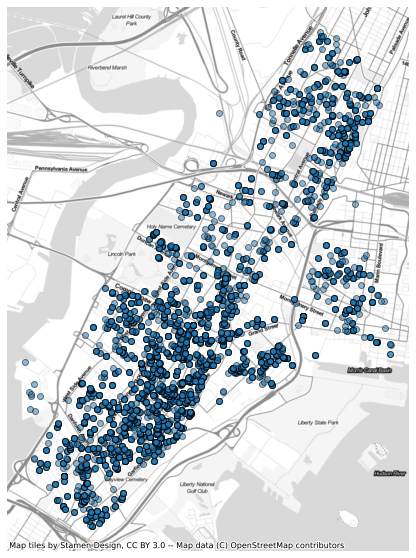

In [4]:
# quickmap 
gdf_tmp = gdf.set_crs(epsg=4326)
gdf_reproj = gdf_tmp.to_crs(epsg=3857)
ax = gdf_reproj.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()

# EXPLORATION

In [5]:
gdf['type'].value_counts()

Vacant       4057
Abandoned     170
Name: type, dtype: int64

In [6]:
# list dates in the database
np.sort(gdf['date'].unique())

array(['2014-07-01T00:00:00.000000000', '2016-07-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2021-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
# by year, type
gdf_by_date_type = gdf.groupby(['date', 'type'])
gdf_by_date_type[['date','type']].agg('count')

date  type
date       type                 
2014-07-01 Abandoned    20    20
           Vacant      902   902
2016-07-01 Abandoned    21    21
           Vacant      885   885
2017-01-01 Abandoned    26    26
           Vacant      832   832
2018-07-01 Abandoned    40    40
           Vacant      860   860
2021-07-01 Abandoned    63    63
           Vacant      578   578

# zone tables

## by ward

In [ ]:
ward_map = gpd.read_file('./maps/wards/ward2012.shp')
ward_map = ward_map.to_crs(epsg=4326)
ward_map.crs               

In [ ]:
ward_map.plot()

In [ ]:
# spatial join
gdf_by_ward=gpd.sjoin(gdf, ward_map, how='left', predicate="within")
gdf_by_ward

In [ ]:
gdf_by_ward[['street_address','WARD2']]

In [ ]:
# by ward, year, type
gdf_by_ward_date_type = gdf_by_ward.groupby(['WARD2','date'])
gdf_by_ward_date_type[['date','WARD2']].agg('count')

## by neighborhood

In [ ]:
neighborhood_map = gpd.read_file('./maps/neighborhoods/Neighborhoods3.shp')
neighborhood_map.crs           

In [ ]:
neighborhood_map = neighborhood_map.to_crs(epsg=4326)
neighborhood_map.plot()  

In [ ]:
# spatial join
gdf_by_neighborhood=gpd.sjoin(gdf, neighborhood_map, how='left', predicate="within")
gdf_by_neighborhood

In [ ]:
gdf_by_neighborhood.columns

In [ ]:
gdf_by_neighborhood[['street_address','Nghbhd']]

# TODO GROUPBY NEIGHBORHOOD, AGG BY YEAR, COUNT 

# by property

In [ ]:
# problem children
repeat_offenders = gdf.groupby('street_address').size().sort_values(ascending=False)
repeat_offenders

In [ ]:
# display first case
i = 0

for street_address,record_count in repeat_offenders.iteritems():
    group = gdf.groupby('street_address').get_group(street_address)
    display(group[['street_address', 'date', 'type']])
    if i==1:
        break
    i += 1

# by time

In [ ]:
# just ones on the list in 2018 and 2021
filtered = gdf[gdf["date"] > datetime.datetime(2018,1,1) ]
filtered


In [ ]:
result = filtered.groupby('street_address').size().sort_values(ascending=False)
result

In [ ]:
# display first 5 cases
i = 0

for street_address,record_count in result.iteritems():
    group = filtered.groupby('street_address').get_group(street_address)
    display(group[['street_address', 'date', 'type']])
    if i==5:
        break
    i += 1

In [ ]:
# when does a property first show up
first_records = gdf[['street_address','date']].groupby(['street_address']).first()
first_records

In [ ]:
last_records = gdf[['street_address','date']].groupby(['street_address']).last()
last_records

In [ ]:
duration_on_list = first_records.join(last_records,  how='left', lsuffix='_left', rsuffix='_right')
duration_on_list['duration'] = duration_on_list['date_right'] - duration_on_list['date_left']
duration_on_list.sort_values(['date_right'], ascending=False)

## abandoned only

In [ ]:
# abandoned for more than 1 time period
gdf_a = gdf[gdf["type"] == 'Abandoned' ]
for index, value in (gdf_a.groupby('street_address').size().sort_values(ascending=False)).iteritems():
    print (index, '\t\t\t', value )

# PRESENTATION

In [ ]:
gdf['date'].unique()

In [ ]:
# filter by date
gdf_cropped = gdf[gdf['date']==datetime.datetime(2021,7,1)]
gdf_cropped.shape

### folium marker map (1 year)

In [ ]:
# MAKE MAP
# https://geopandas.readthedocs.io/en/latest/gallery/plotting_with_folium.html

# Stamen Toner
map = folium.Map(
    location=[40.7128,-74.1],
    tiles='Stamen Toner',
    zoom_start=14)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in gdf_av_cropped.geometry ]


# Iterate through list and add a marker for each address, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    #assign a color marker for the type
    if gdf_cropped['type'].iloc[i] == "Abandoned":
        type_color = "red"
    elif gdf_cropped['type'].iloc[i] == "Vacant":
        type_color = "orange"
    else:
        type_color = "gray"

        
    # alternate symbol
    # adapted from
    # https://stackoverflow.com/questions/33575053/change-marker-in-folium-map
    # and https://stackoverflow.com/questions/63152298/updating-folium-changed-the-popup-box-width
    
    html = "Address: " + str(gdf_cropped.street_address.iloc[i]) + '<br>' + \
           "Date: " + str(gdf_cropped.date.iloc[i]) + '<br>' + \
           "Status: " + str(gdf_cropped['type'].iloc[i])
    iframe = folium.IFrame(html)
    popup = folium.Popup(iframe,
                         min_width=250,
                         max_width=250)
    
    map.add_child(folium.CircleMarker(location = coordinates, 
                                      radius = 5, 
                                      popup = popup,
                                      fill_color=type_color,
                                      color=type_color, 
                                      fill_opacity=0.7))
    
    i = i + 1

# draw map
map

In [ ]:
# TODO cluster analysis?

***

# TODO

## TODO heatmap

In [ ]:
# https://geopandas.readthedocs.io/en/latest/gallery/plotting_with_folium.html

# This example uses heatmaps to visualize the density of volcanoes
# which is more in some parts of the world compared to others.

from folium import plugins

map = folium.Map(location = [15,30], tiles='Cartodb dark_matter', zoom_start = 2)

heat_data = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry ]

heat_data
plugins.HeatMap(heat_data).add_to(map)

map

## TODO a map using marker clusters (what's the mapped variable?)

In [ ]:
# # folium marker clusters
# from folium.plugins import MarkerCluster
# locations = []

# # City location geometries to a list of latlongs pairs  
# for idx, row in gdf.iterrows():
#     locations.append([row['geometry'].y, row['geometry'].x])

#     # Empty canvas
# m = folium.Map(
#     location=[40.7128,-74.1],
#     tiles='Stamen Toner',
#     zoom_start=12)

# # Markercluster
# m.add_child(MarkerCluster(locations=locations))
# m

## parcel polygons map

In [ ]:
# # load the parcel map shapefile as a gdf
# parcelmap = gpd.read_file(r'../../_gis/maps/NJ/_017_HUDSON/parcels_shp_dbf_Hudson/HudsonCountyParcels.shp')

In [ ]:
# parcelmap.plot(figsize=(17,17))

## TODO a chloropleth on parcels what's the mapped variable?)

In [ ]:
# chloropleth mapping in Folium
# https://medium.com/analytics-vidhya/create-and-visualize-choropleth-map-with-folium-269d3fd12fa0

In [ ]:
# # parcels map
# style_function = lambda x: {'fillColor': '#00ff00'}

# jc_parcels_gdf = geopandas.read_file('https://njgin.state.nj.us/download2/parcels/parcels_shp_dbf_Hudson.zip')
# folium.GeoJson(data=jc_parcels_gdf["geometry"], style_function=style_function).add_to(map)
# map